Here we are going to train Small BERT on Extra Processed data file, taking 20% not equally sampled examples 


References:- 

[1] TensorFlow Team. (2022, January 11). Classify text with BERT. Retrieved from https://www.tensorflow.org/text/tutorials/classify_text_with_bert

[2] Google. (n.d.). BERT: Pre-trained models for natural language processing. TensorFlow Hub. Retrieved from https://tfhub.dev/google/collections/bert/1

## Importing Libraries

In [ ]:
# Import the `train_test_split` function from the `sklearn.model_selection` module.
from sklearn.model_selection import train_test_split

# Import the `pandas` and `numpy` modules.
import pandas as pd
import numpy as np

# Install the `tf-models-official` package.
!pip install tf-models-official

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 16.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 53.6 MB/s eta 0:00:00
  C

In [ ]:
# Install the `tensorflow_text` package.
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import the `os` and `shutil` modules to manage files and directories.
import os
import shutil
# Import the `tensorflow` based modules, which provides the core TensorFlow functionality.
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

# Import the `matplotlib.pyplot` module, which provides plotting functionality.
import matplotlib.pyplot as plt
# Set the logging level for TensorFlow to `ERROR` to suppress non-error messages.

tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load and Preprocess the data

In [ ]:
# Read the JSON file `extra_processed.json` into a Pandas DataFrame
data = pd.read_json("drive/MyDrive/extra_processed.json")

In [ ]:
# Randomly sample 20% of the DataFrame.
data = data.sample(int(0.2 * len(data)))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
len(data)

114782

In [ ]:
# Split the DataFrame `data` into a training set and a test set, with 70% of the data in the training set and 30% in the test set.
df_train, df_test = train_test_split(data, train_size = 0.7)

In [ ]:
# Convert the `df_train` and `df_test` DataFrames to TensorFlow Datasets.
train_data = tf.data.Dataset.from_tensor_slices((df_train.review_text, df_train.is_spoiler))
test_data = tf.data.Dataset.from_tensor_slices((df_test.review_text, df_test.is_spoiler))

- The `shuffle` method randomly reorders the elements in the Dataset.
- The `batch` method groups the elements in the Dataset into batches of the specified size.
- The `cache` method stores the Dataset in memory so that it can be accessed more quickly.
- The `prefetch` method loads the next batch of data into memory in the background so that it is ready to be used when needed.

In [ ]:
train_ds = train_data.shuffle(1000).batch(32).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
test_ds = test_data.shuffle(1000).batch(32).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Print the length of the training and test datasets.

In [ ]:
print(len(train_ds))

2511


In [ ]:
print(len(test_ds))

1077


## Get Small BERT from Tensorflow Hub

In [ ]:
# The `tfhub_handle_encoder` variable stores the URL of the TensorFlow Hub module that contains the Small BERT encoder.
# The `tfhub_handle_preprocess` variable stores the URL of the TensorFlow Hub module that contains the Small BERT preprocess model.
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
# Create a TensorFlow Hub layer that loads the BERT preprocess model.
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
# we are basically trying the untrained model on a sample review
text_test = ['this is a sample review']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 1037 7099 3319  102    0    0    0    0    0]
Input Mask : [1 1 1 1 1 1 1 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# Create a TensorFlow Hub layer that loads the BERT encoder model.
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
# Get Small BERT output for sample review
# Obtaining the BERT model outputs for the preprocessed text
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Pooled Outputs Shape:(1, 128)
Pooled Outputs Values:[-0.9999865  -0.01405334 -0.99603784  0.19296533 -0.9975125   0.17602667
 -0.9597754  -0.9617459  -0.01682891 -0.00425104 -0.86016166 -0.06735554]
Sequence Outputs Shape:(1, 128, 128)
Sequence Outputs Values:[[-1.5439038   0.82710624 -2.86205    ... -0.9239646  -0.46356803
  -0.6554003 ]
 [-2.1767814   1.015919    0.29913726 ... -2.0596004  -0.5593701
  -0.1393905 ]
 [-2.0430946   0.9145409   0.06425074 ... -1.8118677  -0.73687273
  -0.58737636]
 ...
 [-0.5783801   0.30314168 -0.14225285 ... -2.4814286  -0.00661103
   0.51748663]
 [-0.70947254  0.60380465 -0.11880247 ... -2.3358333  -0.27926797
   0.47840878]
 [-0.7461271   0.6653263  -0.09691314 ... -2.0960393  -0.55429363
   0.4648037 ]]


## Define Model

In [ ]:

def build_classifier_model():

  """
  This function builds a classifier model using a BERT encoder.
  
  Returns:
    A TensorFlow Keras model.
  """
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
# Create the classifier Model 
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.34240067]], shape=(1, 1), dtype=float32)


In [ ]:
# Print model summary
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

## Model Training

### Loss function and metrics

In [ ]:
# Define the loss and metrics for the classifier model.

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). 

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Compiling Model

In [ ]:
# The model is compiled using the specified optimizer, loss function, and metrics.
classifier_model.compile(optimizer= optimizer,
                         loss=loss,
                         metrics=metrics)

## Training Model

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=test_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/5
2511/2511 [==============================] - 356s 140ms/step - loss: 0.5690 - binary_accuracy: 0.7332 - val_loss: 0.5385 - val_binary_accuracy: 0.7368
Epoch 2/5
2511/2511 [==============================] - 368s 146ms/step - loss: 0.5304 - binary_accuracy: 0.7451 - val_loss: 0.5242 - val_binary_accuracy: 0.7507
Epoch 3/5
2511/2511 [==============================] - 330s 131ms/step - loss: 0.5151 - binary_accuracy: 0.7531 - val_loss: 0.5268 - val_binary_accuracy: 0.7522
Epoch 4/5
2511/2511 [==============================] - 325s 130ms/step - loss: 0.5066 - binary_accuracy: 0.7568 - val_loss: 0.5259 - val_binary_accuracy: 0.7528
Epoch 5/5
2511/2511 [==============================] - 328s 131ms/step - loss: 0.4990 - binary_accuracy: 0.7609 - val_loss: 0.5254 - val_binary_accuracy: 0.7532


In [ ]:
## Training for 5 more epochs 
history_further = classifier_model.fit(x=train_ds,
                               validation_data=test_ds,
                               epochs=epochs)

Epoch 1/5
2511/2511 [==============================] - 329s 131ms/step - loss: 0.4961 - binary_accuracy: 0.7611 - val_loss: 0.5254 - val_binary_accuracy: 0.7532
Epoch 2/5
2511/2511 [==============================] - 325s 129ms/step - loss: 0.4966 - binary_accuracy: 0.7603 - val_loss: 0.5254 - val_binary_accuracy: 0.7532
Epoch 3/5
2511/2511 [==============================] - 324s 129ms/step - loss: 0.4961 - binary_accuracy: 0.7612 - val_loss: 0.5254 - val_binary_accuracy: 0.7532
Epoch 4/5
2511/2511 [==============================] - 331s 132ms/step - loss: 0.4961 - binary_accuracy: 0.7607 - val_loss: 0.5254 - val_binary_accuracy: 0.7532
Epoch 5/5
2511/2511 [==============================] - 335s 134ms/step - loss: 0.4976 - binary_accuracy: 0.7606 - val_loss: 0.5254 - val_binary_accuracy: 0.7532


### Plot Accuracy vs epochs curves

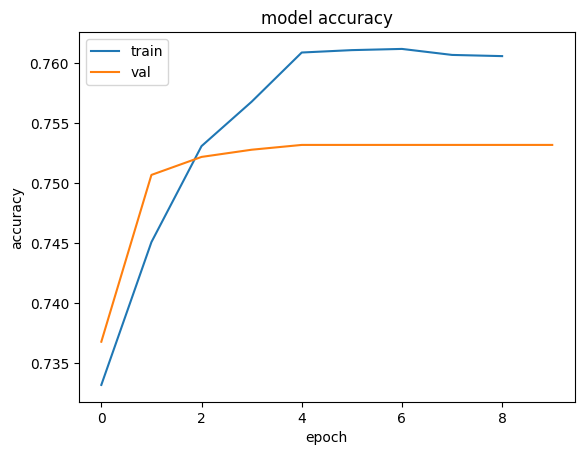

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()




### Plot the loss vs epochs curves

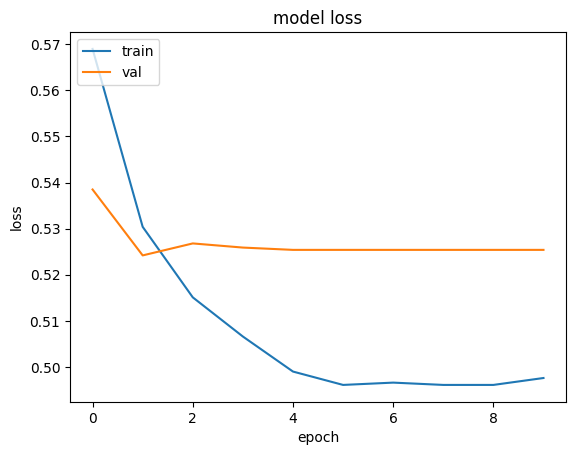

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Evalute the Model

- Accuracy
- F1 Score
- Recall
- Precision
- Support

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Predict labels for test data
y_pred = classifier_model.predict(df_test["review_text"])

1077/1077 [==============================] - 244s 225ms/step


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
# The model's predictions are in the form of a probability.
# We use the sigmoid function to convert the probabilities to binary values.
y_pred = tf.sigmoid(y_pred)
# We then use the numpy where function to convert any probabilities greater than or equal to 0.5 to 1, and any probabilities less than 0.5 to 0.
# y_pred = np.where(y_pred.numpy() >= 0.5, 1, 0)
le = LabelEncoder()
test_labels = le.fit_transform(df_test.is_spoiler)
# We then calculate the precision, recall, fbeta_score, and support for the model's predictions.
precision, recall, fbeta_score, support = precision_recall_fscore_support(test_labels, y_pred)

In [ ]:
print(le.classes_)
# Get Precision for both classes
print(precision)
# Get Recall for both classes
print(recall)
# Get F1 score for both classes
print(fbeta_score)

[False  True]
[0.77855596 0.53863497]
[0.91089383 0.28649297]
[0.83954176 0.37403928]


### Confusion Matrix

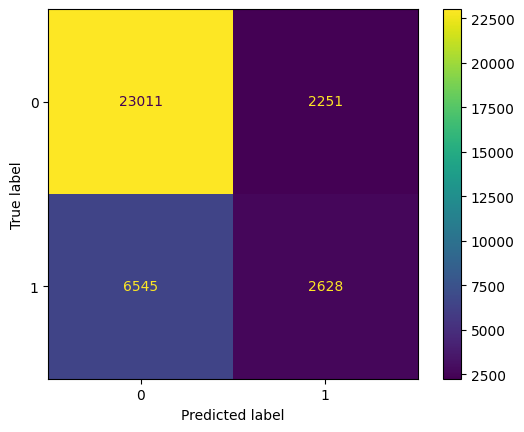

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred)
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Save The Model for further Inference

In [ ]:
classifier_model.save("small_bert_extra_10.tf")

In [ ]:
import shutil
shutil.make_archive("small_bert_extra_10", 'zip', "small_bert_extra_10.tf")

'/content/small_bert_extra_10.zip'